In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [2]:
training_corpus = fetch_20newsgroups(subset='train')

In [3]:
print('Training data size : {}'.format(len(training_corpus.data)))

Training data size : 11314


In [4]:
training_corpus.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
training_corpus.target

array([7, 4, 4, ..., 3, 1, 8])

In [6]:
print(training_corpus.data[0])
first_doc_label = training_corpus.target[0]
print('Label for this post: {}'.format(first_doc_label))
print('Corresponding topic: {}'.format(training_corpus.target_names[first_doc_label]))

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





Label for this post: 7
Corresponding topic: rec.autos


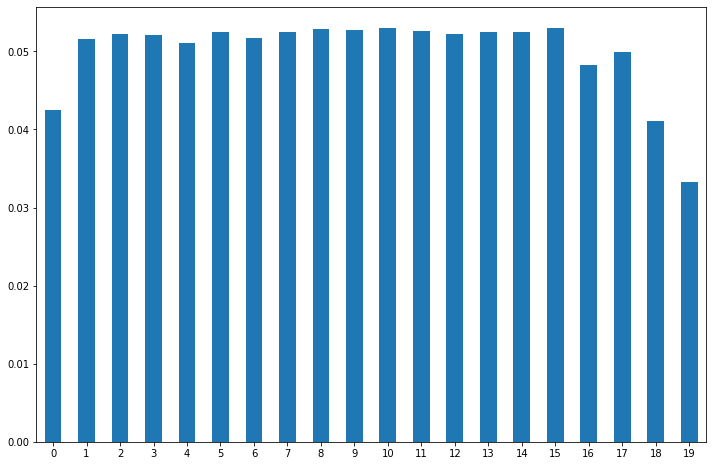

In [7]:
bins, counts = np.unique(training_corpus.target, return_counts=True)
freq_series = pd.Series(counts/len(training_corpus.data))
plt.figure(figsize=(12,8))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.show()

In [8]:
train_data, val_data, train_labels, val_labels = train_test_split(training_corpus.data, training_corpus.target, train_size=0.8, random_state=1) 
print('Training data size: {}'.format(len(train_data)))
print('Validation data size: {}'.format(len(val_data)))

Training data size: 9051
Validation data size: 2263


In [9]:
nlp = spacy.load('en_core_web_sm')

In [10]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [11]:
nlp = spacy.blank('en') #this will perform just tokenization
nlp.pipe_names

[]

In [12]:
def spacy_tokenizer(doc):
    return [t.text for t in nlp(doc) if \
            not t.is_punct and \
            not t.is_space and \
            t.is_alpha]

In [13]:
%%time
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
train_feature_vects = vectorizer.fit_transform(train_data)

CPU times: total: 42.5 s
Wall time: 42.7 s


In [14]:
nb_classifier = MultinomialNB()
nb_classifier.fit(train_feature_vects, train_labels)
nb_classifier.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [15]:
train_preds = nb_classifier.predict(train_feature_vects)
print('F1 score on initial training set: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

F1 score on initial training set: 0.8982344792497875


In [16]:
filtered_training_corpus = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
train_data, val_data, train_labels, val_labels = train_test_split(filtered_training_corpus.data, filtered_training_corpus.target, train_size=0.8, random_state=1) 

In [17]:
train_data[0]

"\nI don't know about that...I've used Photoshop 2.5 on both a 486dx-50 and a Quadra\n950...I'd say they are roughly equal.  If anything the 486 was faster."

In [18]:
%%time
train_feature_vects = vectorizer.fit_transform(train_data)
nb_classifier.fit(train_feature_vects, train_labels)

CPU times: total: 15.5 s
Wall time: 15.5 s


MultinomialNB()

In [19]:
train_preds = nb_classifier.predict(train_feature_vects)
print('F1 score on filtered training set: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro'))) 

F1 score on filtered training set: 0.791654644597863


In [20]:
%%time
val_feature_vects = vectorizer.transform(val_data)

CPU times: total: 3.69 s
Wall time: 3.69 s


In [21]:
val_preds = nb_classifier.predict(val_feature_vects)
print('F1 score on filtered validation set: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

F1 score on filtered validation set: 0.6087677070998413


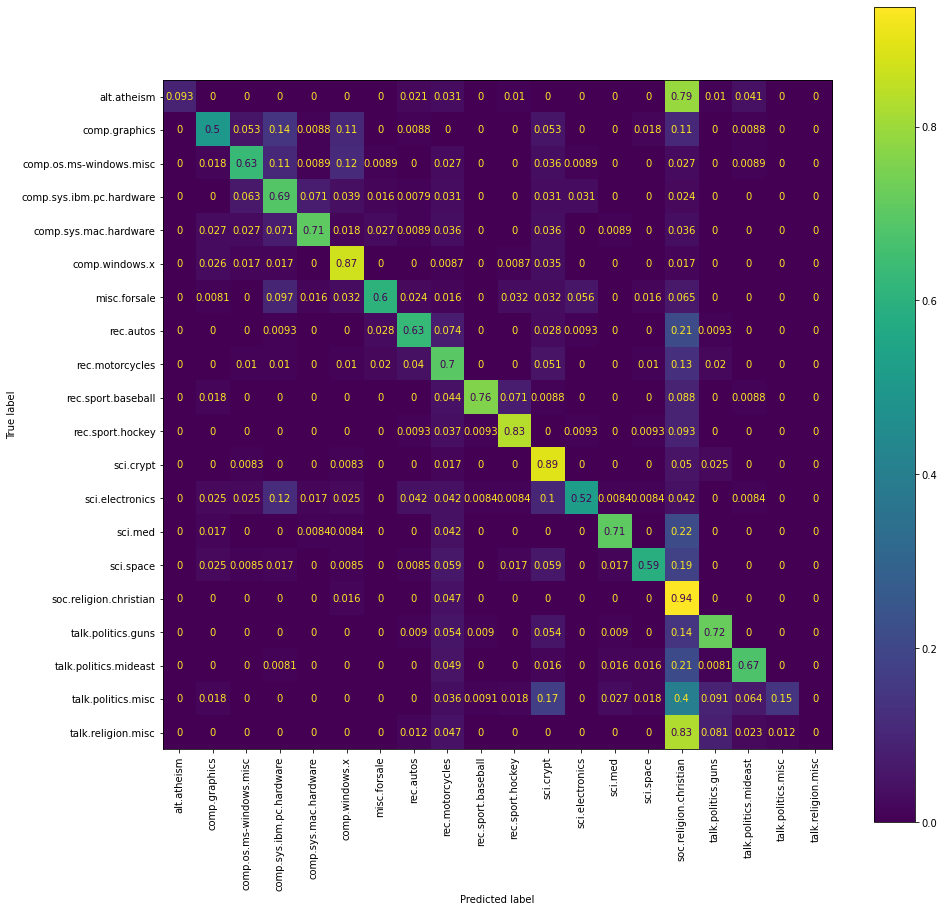

In [22]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay.from_estimator(nb_classifier, val_feature_vects, val_labels, normalize='true', display_labels=filtered_training_corpus.target_names, xticks_rotation='vertical', ax=ax)

In [23]:
print(metrics.classification_report(val_labels, val_preds, target_names=filtered_training_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       1.00      0.09      0.17        97
           comp.graphics       0.73      0.50      0.59       114
 comp.os.ms-windows.misc       0.74      0.63      0.68       112
comp.sys.ibm.pc.hardware       0.56      0.69      0.61       127
   comp.sys.mac.hardware       0.83      0.71      0.76       112
          comp.windows.x       0.69      0.87      0.77       115
            misc.forsale       0.87      0.60      0.71       124
               rec.autos       0.76      0.63      0.69       108
         rec.motorcycles       0.47      0.70      0.56        99
      rec.sport.baseball       0.96      0.76      0.85       113
        rec.sport.hockey       0.83      0.83      0.83       108
               sci.crypt       0.57      0.89      0.69       120
         sci.electronics       0.82      0.52      0.64       119
                 sci.med       0.89      0.71      0.79       119
         

c:\Users\Abhipreet\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abhipreet\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abhipreet\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

## Improving the model

In [24]:
print('Training data size: {}'.format(len(train_data)))
print('Number of training features: {}'.format(len(train_feature_vects[0].toarray().flatten())))

Training data size: 9051
Number of training features: 51637


The number of features is much higher than the number of training samples

In [25]:
nlp = spacy.load('en_core_web_sm')
unwanted_pipes = ['ner', 'parser']

def spacy_tokenizer(doc):
  with nlp.disable_pipes(*unwanted_pipes):
    return [t.lemma_ for t in nlp(doc) if \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop and \
            t.is_alpha]

In [26]:
%%time
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
train_feature_vects = vectorizer.fit_transform(train_data)

CPU times: total: 3min 5s
Wall time: 3min 5s


In [27]:
print('Number of training features: {}'.format(len(train_feature_vects[0].toarray().flatten())))

Number of training features: 42714


In [28]:
nb_classifier.fit(train_feature_vects, train_labels)
train_preds = nb_classifier.predict(train_feature_vects)
print('Training F1 score with fewer features: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

Training F1 score with fewer features: 0.8398883700432671


In [29]:
%%time
val_feature_vects = vectorizer.transform(val_data)

CPU times: total: 44.1 s
Wall time: 44.3 s


In [30]:
val_preds = nb_classifier.predict(val_feature_vects)
print('Validation F1 score with fewer features: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

Validation F1 score with fewer features: 0.6723713085312655


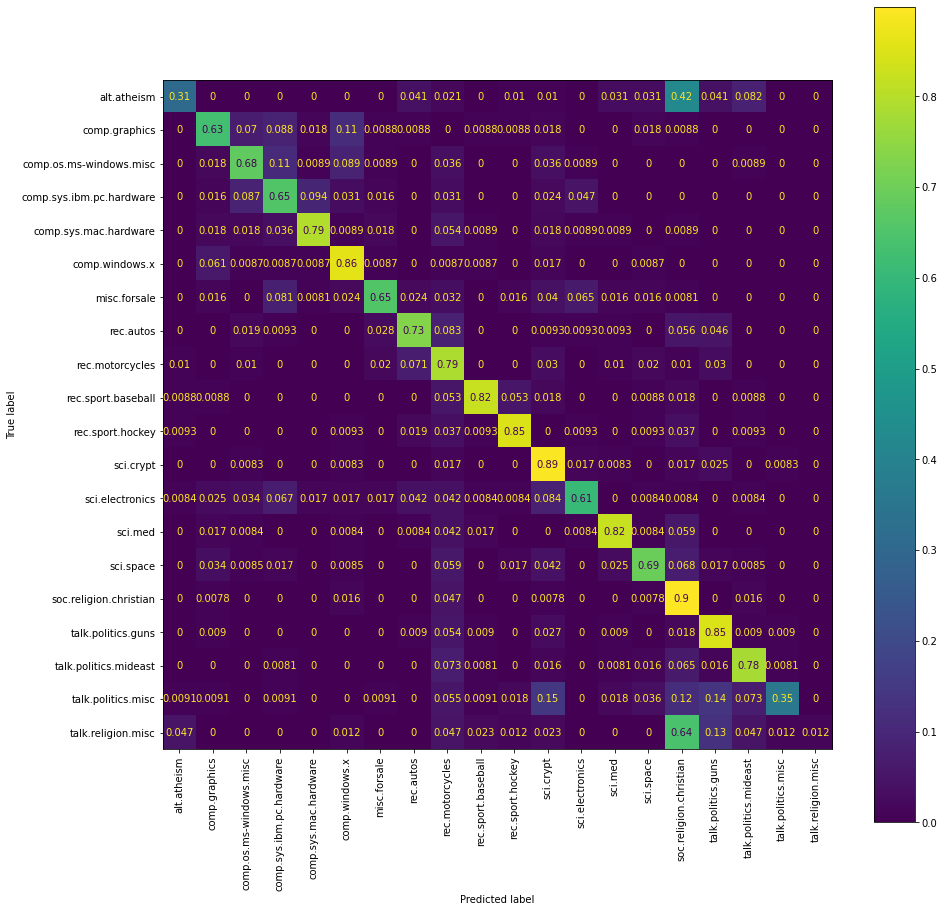

In [31]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay.from_estimator(nb_classifier, val_feature_vects, val_labels, normalize='true', display_labels=filtered_training_corpus.target_names, xticks_rotation='vertical', ax=ax)

In [32]:
print(metrics.classification_report(val_labels, val_preds, target_names=filtered_training_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.77      0.31      0.44        97
           comp.graphics       0.72      0.63      0.67       114
 comp.os.ms-windows.misc       0.70      0.68      0.69       112
comp.sys.ibm.pc.hardware       0.62      0.65      0.64       127
   comp.sys.mac.hardware       0.82      0.79      0.81       112
          comp.windows.x       0.71      0.86      0.78       115
            misc.forsale       0.84      0.65      0.74       124
               rec.autos       0.77      0.73      0.75       108
         rec.motorcycles       0.46      0.79      0.58        99
      rec.sport.baseball       0.89      0.82      0.85       113
        rec.sport.hockey       0.85      0.85      0.85       108
               sci.crypt       0.63      0.89      0.74       120
         sci.electronics       0.77      0.61      0.68       119
                 sci.med       0.86      0.82      0.84       119
         

In [33]:
# The alpha values to try.
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0,],}

# Instantiate the search with the model we want to try and fit it on the training data.
multinomial_nb_grid = model_selection.GridSearchCV(MultinomialNB(), param_grid=params, scoring='f1_macro', n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(train_feature_vects, train_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]},
             scoring='f1_macro', verbose=5)

In [34]:
print('Best parameter value(s): {}'.format(multinomial_nb_grid.best_params_))

Best parameter value(s): {'alpha': 0.01}


In [35]:
best_nb_classifier = multinomial_nb_grid.best_estimator_
val_preds = best_nb_classifier.predict(val_feature_vects)
print('Validation F1 score with fewer features: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

Validation F1 score with fewer features: 0.7321088520594417


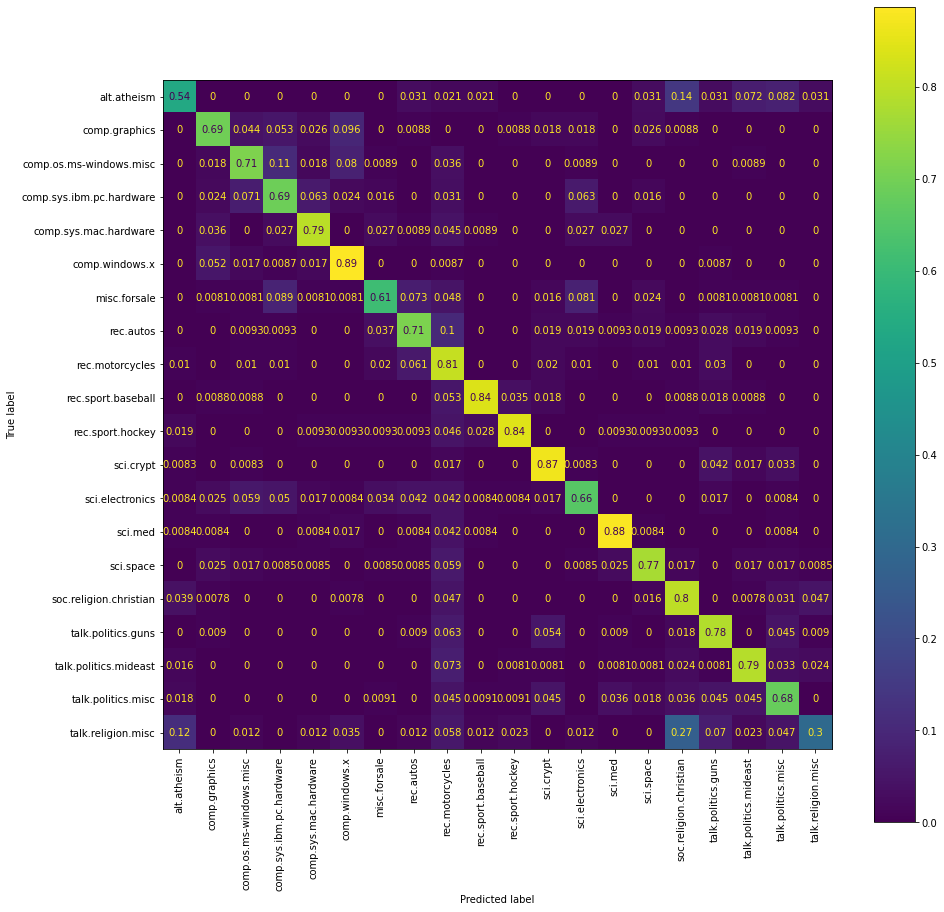

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay.from_estimator(best_nb_classifier, val_feature_vects, val_labels, normalize='true', display_labels=filtered_training_corpus.target_names, xticks_rotation='vertical', ax=ax)

In [37]:
print(metrics.classification_report(val_labels, val_preds, target_names=filtered_training_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.68      0.54      0.60        97
           comp.graphics       0.75      0.69      0.72       114
 comp.os.ms-windows.misc       0.72      0.71      0.72       112
comp.sys.ibm.pc.hardware       0.68      0.69      0.68       127
   comp.sys.mac.hardware       0.80      0.79      0.80       112
          comp.windows.x       0.76      0.89      0.82       115
            misc.forsale       0.80      0.61      0.69       124
               rec.autos       0.72      0.71      0.72       108
         rec.motorcycles       0.46      0.81      0.58        99
      rec.sport.baseball       0.90      0.84      0.87       113
        rec.sport.hockey       0.90      0.84      0.87       108
               sci.crypt       0.81      0.87      0.84       120
         sci.electronics       0.72      0.66      0.69       119
                 sci.med       0.88      0.88      0.88       119
         

In [38]:
def show_top_words(classifier, vectorizer, categories, top_n):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        prob_sorted = classifier.feature_log_prob_[i,:].argsort()[::-1]
        print("%s: %s" % (category, " ".join(feature_names[prob_sorted[:top_n]])))

In [39]:
show_top_words(best_nb_classifier, vectorizer, filtered_training_corpus.target_names, 10)

alt.atheism: god religion atheist people think say atheism post belief believe
comp.graphics: file graphic image thank program format look know color software
comp.os.ms-windows.misc: window file driver problem use program card do thank font
comp.sys.ibm.pc.hardware: drive card controller bus scsi monitor ide mb thank pc
comp.sys.mac.hardware: mac apple drive problem monitor card thank work simms quadra
comp.windows.x: x window server widget motif application use run thank program
misc.forsale: sale offer shipping sell price new include email condition drive
rec.autos: car engine drive like dealer good new buy oil look
rec.motorcycles: bike ride motorcycle dod helmet like rider go think know
rec.sport.baseball: game year team baseball hit win player run fan pitch
rec.sport.hockey: game team play hockey player season playoff nhl win year
sci.crypt: key encryption chip clipper government system nsa phone escrow bit
sci.electronics: power use circuit know like work chip ground try line
sc

c:\Users\Abhipreet\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_feature_vects, train_labels)
dummy_clf.score(val_feature_vects, val_labels)

0.043747238179407864

In [41]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(train_feature_vects, train_labels)
dummy_clf.score(val_feature_vects, val_labels)

0.047724259832081305

In [42]:
text_classifier = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
    ('classifier', MultinomialNB(alpha=0.01))
])

In [43]:
%%time
text_classifier.fit(filtered_training_corpus.data, filtered_training_corpus.target)

CPU times: total: 4min 6s
Wall time: 4min 20s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x000002708FB16700>)),
                ('classifier', MultinomialNB(alpha=0.01))])

In [44]:
filtered_test_corpus = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [45]:
%%time
test_preds = text_classifier.predict(filtered_test_corpus.data)

CPU times: total: 2min 45s
Wall time: 2min 46s


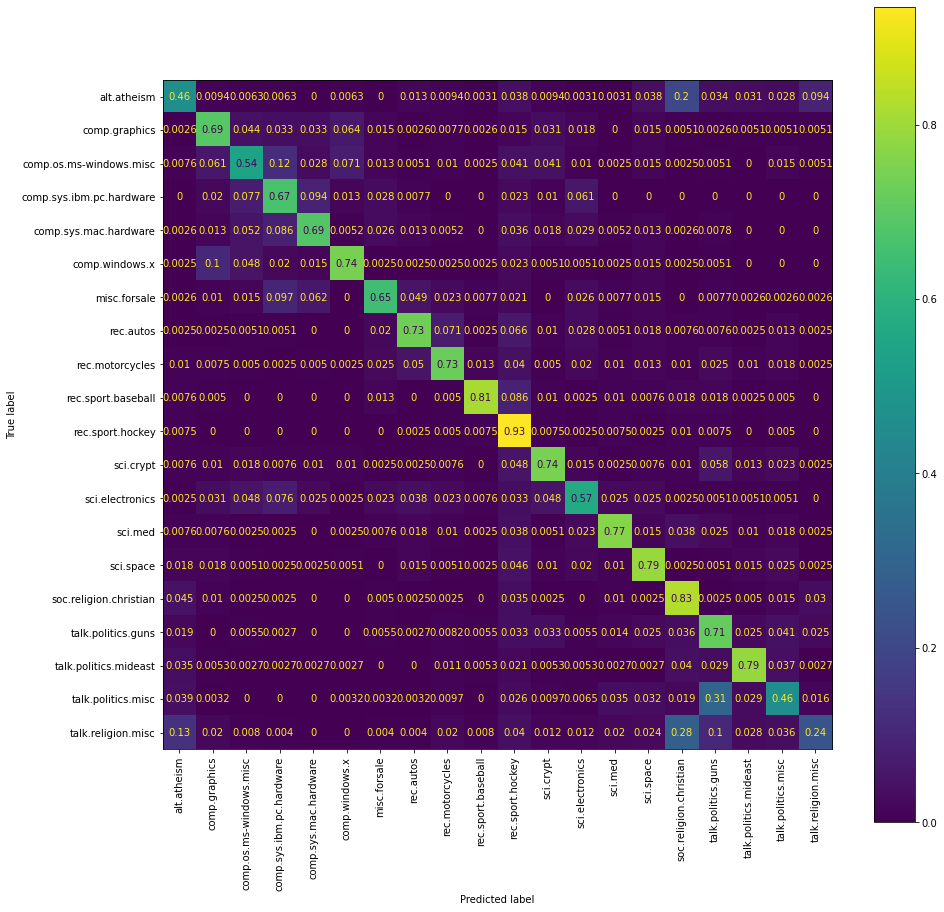

CPU times: total: 1.69 s
Wall time: 2.33 s


In [46]:
%%time
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(filtered_test_corpus.target, test_preds, normalize='true', display_labels=filtered_test_corpus.target_names, xticks_rotation='vertical', ax=ax)
plt.show()

In [47]:
print(metrics.classification_report(filtered_test_corpus.target, test_preds, target_names=filtered_test_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.56      0.46      0.51       319
           comp.graphics       0.68      0.69      0.68       389
 comp.os.ms-windows.misc       0.62      0.54      0.58       394
comp.sys.ibm.pc.hardware       0.59      0.67      0.62       392
   comp.sys.mac.hardware       0.71      0.69      0.70       385
          comp.windows.x       0.80      0.74      0.77       395
            misc.forsale       0.77      0.65      0.70       390
               rec.autos       0.77      0.73      0.75       396
         rec.motorcycles       0.77      0.73      0.75       398
      rec.sport.baseball       0.92      0.81      0.86       397
        rec.sport.hockey       0.58      0.93      0.72       399
               sci.crypt       0.74      0.74      0.74       396
         sci.electronics       0.67      0.57      0.62       393
                 sci.med       0.83      0.77      0.80       396
         

In [51]:
def classify_text(clf, doc, labels=None):
  probas = clf.predict_proba([doc]).flatten()
  max_proba_idx = np.argmax(probas)
  
  if labels:
    most_proba_class = labels[max_proba_idx]
  else:
    most_proba_class = max_proba_idx

  return (most_proba_class, probas[max_proba_idx])

In [54]:
# Post from r/medicine.
s = "Hello everyone so am doing my thesis on Ischemic heart disease have been using online articles and textbooks mostly Harrisons internal med. could u recommended me some source specifically books where i can get more about in depth knowledge on IHD."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('sci.med', 0.7852448884156163)

In [55]:
# Post from r/space.
s = "First evidence that water can be created on the lunar surface by Earth's magnetosphere. Particles from Earth can seed the moon with water, implying that other planets could also contribute water to their satellites."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('sci.space', 0.967173327740258)

In [56]:
# Post from r/cars.
s = "New Toyota 86 Launch Reportedly Delayed to 2022, CEO Doesn't Want a Subaru Copy"
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('rec.autos', 0.8448310429495018)

In [57]:
# Post from r/electronics.
s = "My First Ever Homemade PCB. My SMD Soldering Skills Aren't Great, But I'm Quite Proud of it."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('sci.electronics', 0.9253245234781562)